In [1]:
import os
import cv2
import copy
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Init Param

In [2]:
freq_print = 20

use_gpu = True
torch.backends.cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
use_cuda

True

### Define TestFolder Class

In [3]:
class TestImageFolder(Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

### Define Transform

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Split Train and test

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

train_dataset = datasets.ImageFolder('./data/', train_transform)
valid_dataset = datasets.ImageFolder('./data/', test_transform)
test_dataset = TestImageFolder('./test/', test_transform)

shuffle = True
valid_ratio = 0.15
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_ratio * num_train))

if shuffle:
    np.random.seed(42)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

### Visualise Test Data

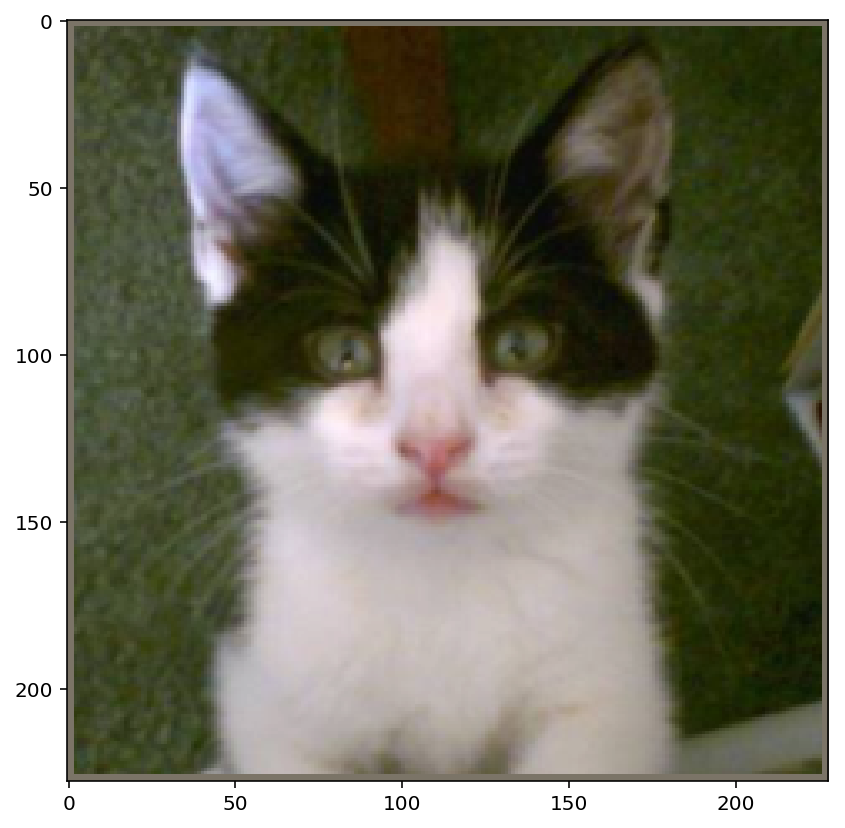

In [6]:
import torchvision.utils as utils
plt.figure(figsize=(12, 7))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

### Define Train Func

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset_sizes = len(train_loader.sampler)
                data_loader = train_loader
                scheduler.step()
                model.train(True)
            else:
                dataset_sizes = len(valid_loader.sampler)
                data_loader = valid_loader
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for ix, data in enumerate(data_loader):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if ix % freq_print == 0:
                    print('Epoch:[{0}][{1}/{2}]\tLoss: {3}\tCorrect: {4}'.format(epoch + 1, ix, len(data_loader), 
                                                                               running_loss / (inputs.size(0)*(ix+1)), 
                                                                               running_corrects / (inputs.size(0)*(ix+1))))

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                torch.save(model, 'best_model.pth.tar')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Modify Model

In [9]:
model_ft = models.resnet152(pretrained=True)
num_feas = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.fc = nn.Linear(num_feas, 2)
model_ft.cuda()

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1):

In [10]:
# Cross Entropy
criterion = nn.CrossEntropyLoss().cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_para = torch.nn.DataParallel(model_ft).cuda()
model_para = train_model(model_para, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=14)

Epoch 1/14
----------
Epoch:[1][0/333]	Loss: 0.6512751579284668	Correct: 0.625
Epoch:[1][20/333]	Loss: 0.4957837760448456	Correct: 0.8162202380952381
Epoch:[1][40/333]	Loss: 0.3677226861075657	Correct: 0.8761432926829268
Epoch:[1][60/333]	Loss: 0.31173280638749484	Correct: 0.8949795081967213
Epoch:[1][80/333]	Loss: 0.2862648802039064	Correct: 0.9016203703703703
Epoch:[1][100/333]	Loss: 0.2642557727965978	Correct: 0.9070235148514851
Epoch:[1][120/333]	Loss: 0.24860323257436437	Correct: 0.9116735537190083
Epoch:[1][140/333]	Loss: 0.2356344628947001	Correct: 0.9155585106382979
Epoch:[1][160/333]	Loss: 0.22686238684084103	Correct: 0.9186723602484472
Epoch:[1][180/333]	Loss: 0.21968101891200187	Correct: 0.9204937845303868
Epoch:[1][200/333]	Loss: 0.21319588774175785	Correct: 0.9228078358208955
Epoch:[1][220/333]	Loss: 0.20896458018958838	Correct: 0.9233597285067874
Epoch:[1][240/333]	Loss: 0.20597957615659446	Correct: 0.9237551867219918
Epoch:[1][260/333]	Loss: 0.20259267464280128	Correct: 

Epoch:[6][200/333]	Loss: 0.13431987474065515	Correct: 0.943407960199005
Epoch:[6][220/333]	Loss: 0.13418134030510936	Correct: 0.9433682126696833
Epoch:[6][240/333]	Loss: 0.13405586159266378	Correct: 0.9431405601659751
Epoch:[6][260/333]	Loss: 0.13321244635287371	Correct: 0.943426724137931
Epoch:[6][280/333]	Loss: 0.1326798341134265	Correct: 0.943672153024911
Epoch:[6][300/333]	Loss: 0.1334155044484376	Correct: 0.9434177740863787
Epoch:[6][320/333]	Loss: 0.13259641134478964	Correct: 0.9437792056074766
train Loss: 0.1332 Acc: 0.9432
Epoch:[6][0/59]	Loss: 0.06467773020267487	Correct: 0.96875
Epoch:[6][20/59]	Loss: 0.04559947670038257	Correct: 0.9866071428571429
Epoch:[6][40/59]	Loss: 0.043467655210051595	Correct: 0.9866615853658537
val Loss: 0.0399 Acc: 0.9880

Epoch 7/14
----------
Epoch:[7][0/333]	Loss: 0.18808215856552124	Correct: 0.890625
Epoch:[7][20/333]	Loss: 0.13259937951252573	Correct: 0.9404761904761905
Epoch:[7][40/333]	Loss: 0.12295942162958587	Correct: 0.9485518292682927
Epoc

Epoch:[11][40/59]	Loss: 0.03628922342436343	Correct: 0.989329268292683
val Loss: 0.0352 Acc: 0.9893

Epoch 12/14
----------
Epoch:[12][0/333]	Loss: 0.03909652680158615	Correct: 1.0
Epoch:[12][20/333]	Loss: 0.1095820903068497	Correct: 0.953125
Epoch:[12][40/333]	Loss: 0.1173910693061061	Correct: 0.9512195121951219
Epoch:[12][60/333]	Loss: 0.11879334244571749	Correct: 0.9505635245901639
Epoch:[12][80/333]	Loss: 0.11736432665292128	Correct: 0.9513888888888888
Epoch:[12][100/333]	Loss: 0.12171505723554309	Correct: 0.9484839108910891
Epoch:[12][120/333]	Loss: 0.11857507785797612	Correct: 0.9506714876033058
Epoch:[12][140/333]	Loss: 0.11730823376552856	Correct: 0.9507978723404256
Epoch:[12][160/333]	Loss: 0.11846261673971363	Correct: 0.9499223602484472
Epoch:[12][180/333]	Loss: 0.1182366287366626	Correct: 0.9500172651933702
Epoch:[12][200/333]	Loss: 0.11746715962775607	Correct: 0.9502487562189055
Epoch:[12][220/333]	Loss: 0.11669577048813326	Correct: 0.9502262443438914
Epoch:[12][240/333]	Lo

### Predict Test

In [15]:
%%time

csv_map = {}
# switch to evaluate mode
model_para.train(False)
model_para.eval()

for i, (images, filepath) in enumerate(test_loader):
    # pop extension, treat as id to map
    filepath = os.path.splitext(os.path.basename(filepath[0]))[0]
    filepath = int(filepath)

    image_var = torch.autograd.Variable(images, volatile=True)
    y_pred = model_para(image_var)
    smax = nn.Softmax()
    
    # get the index of the max log-probability
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob
    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
    prob = np.clip(prob, .0001, .999)
    csv_map[filepath] = prob

/usr/local/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 9min 33s, sys: 30.4 s, total: 10min 4s
Wall time: 10min 4s


### Get Test Result

In [16]:
with open('./result.csv', 'w') as csvfile:
    csvfile.writelines('id,label\n')
    for row in sorted(csv_map.items()):
        csvfile.writelines('{0},{1}\n'.format(row[0], row[1]))